In [54]:
import pixelator
import anndata

import os
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
from pixelator import simple_aggregate

import scanpy as sc


In [ ]:
from pathlib import Path
import pixelator
from pixelator import simple_aggregate


DATA_DIR = Path('./datasets')


FILENAMES = [
    "Sample05_V2_PBMC_r1.layout.dataset.pxl",
    "Sample06_V2_PBMC_r2.layout.dataset.pxl",
    "Sample07_V2_PHA_PBMC_r1.layout.dataset.pxl",
    "Sample08_V2_PHA_PBMC_r2.layout.dataset.pxl",
]

SAMPLE_NAMES = [
    "resting_r1", 
    "resting_r2",
    "stimulated_r1", 
    "stimulated_r2",
]

# COMBINED_FILENAME = "combined_resting_data.pxl"

COMBINED_FILENAME = "combined_resting_PHA_data.pxl"
COMBINED_PROCESSED_NAME = "combined_resting_PHA_data_PROCESSED.pxl"

combined_path = DATA_DIR / COMBINED_FILENAME
if os.path.exists(combined_path):
    pg_data = pixelator.read(combined_path)
else:
    
    baseurl = "https://pixelgen-technologies-datasets.s3.eu-north-1.amazonaws.com/mpx-datasets/pixelator/0.18.x/technote-v1-vs-v2-immunology-II"
    for filename in FILENAMES:
        !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/{filename}"

    datasets = [pixelator.read(DATA_DIR / filename) for filename in FILENAMES]
    pg_data = pixelator.simple_aggregate(
        SAMPLE_NAMES, datasets
    )
    pg_data.save(combined_path, force_overwrite=True)


In [56]:
adata = pg_data.adata
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True, var_type='antibodies')
adata.layers['counts'] = adata.X.copy()
adata.obs

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


,pixels,a_pixels,b_pixels,antibodies,molecules,reads,mean_reads_per_molecule,median_reads_per_molecule,mean_b_pixels_per_a_pixel,median_b_pixels_per_a_pixel,...,mean_molecules_per_a_pixel,median_molecules_per_a_pixel,leiden,tau_type,tau,sample,n_antibodies_by_counts,log1p_n_antibodies_by_counts,total_counts,log1p_total_counts
component,,,,,,,,,,,,,,,,,,,,,
RCVCMP0000000_resting_r1,5833,3749,2084,79,35040,114108,3.256507,3.0,2.794345,2.0,...,9.346492,5.0,0,normal,0.935262,resting_r1,79,4.382027,35040,10.464274
RCVCMP0000001_resting_r1,4769,3338,1431,79,33399,107689,3.224318,3.0,2.933493,2.0,...,10.005692,5.0,1,normal,0.939779,resting_r1,79,4.382027,33399,10.416311
RCVCMP0000002_resting_r1,4227,2724,1503,78,34376,113349,3.297330,3.0,3.825624,3.0,...,12.619677,7.5,0,normal,0.922382,resting_r1,78,4.369448,34376,10.445143
RCVCMP0000004_resting_r1,3285,2159,1126,79,13859,42368,3.057075,3.0,2.352478,2.0,...,6.419176,3.0,2,normal,0.938652,resting_r1,79,4.382027,13859,9.536762
RCVCMP0000005_resting_r1,9958,6413,3545,79,43839,136302,3.109149,3.0,2.397318,2.0,...,6.835958,3.0,3,normal,0.945426,resting_r1,79,4.382027,43839,10.688302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCVCMP0002681_stimulated_r2,1184,784,400,78,2075,5459,2.630843,2.0,1.709184,1.0,...,2.646684,2.0,12,normal,0.865849,stimulated_r2,78,4.369448,2075,7.638198
RCVCMP0002919_stimulated_r2,514,285,229,71,1186,3194,2.693086,2.0,2.273684,2.0,...,4.161404,3.0,1,normal,0.951243,stimulated_r2,71,4.276666,1186,7.079184
RCVCMP0004154_stimulated_r2,223,156,67,65,390,1058,2.712821,2.0,1.608974,1.0,...,2.500000,1.0,12,normal,0.933735,stimulated_r2,65,4.189655,390,5.968708


## Abundance EDA

Each sample has roughly 1000 cells screened for 84 antibodies.

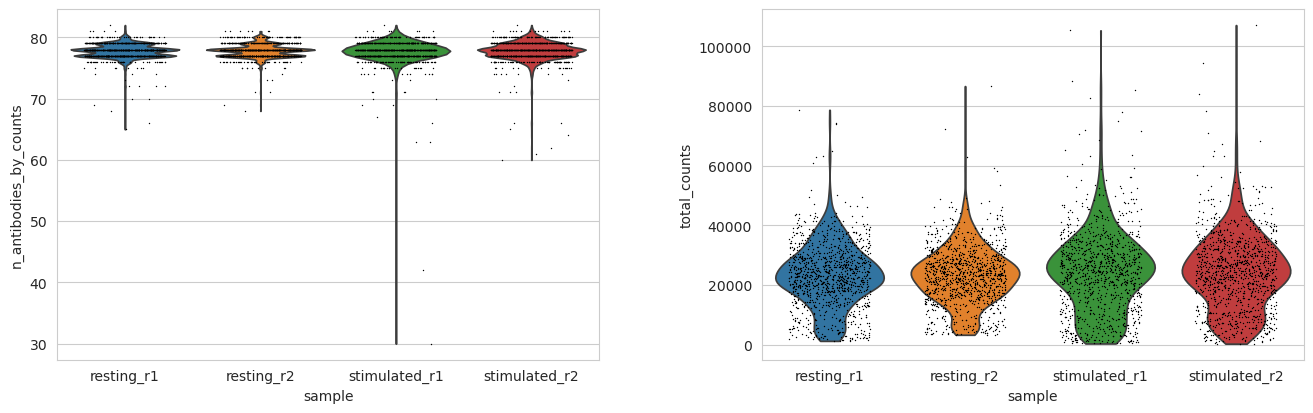

In [57]:
sc.pl.violin(
    adata,
    ["n_antibodies_by_counts", "total_counts",],
    groupby='sample',
    jitter=0.3,
    multi_panel=True,
)

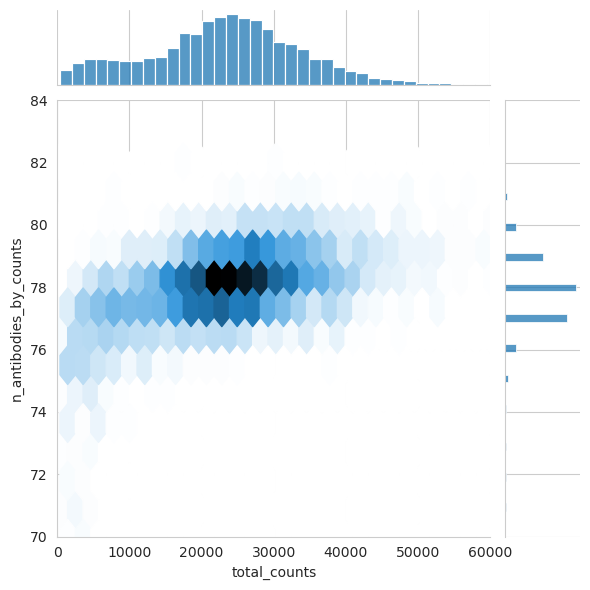

In [58]:
ax = sns.jointplot(
    data=adata.obs,
    x="total_counts",
    y="n_antibodies_by_counts",
    kind="hex",
    xlim=(0, 60*1000),
    ylim=(70, 84)
)

## Filtering data according to abundance "elbow point" and PixelGen Tau specificity
Low or high tau indicates the component is not a cell (antibody aggregate or other debris)

/tmp/ipykernel_3576586/144373203.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/pixelator/plot/__init__.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  edge_rank_df["rank"] = edge_rank_df.groupby([group_by])["molecules"].rank(


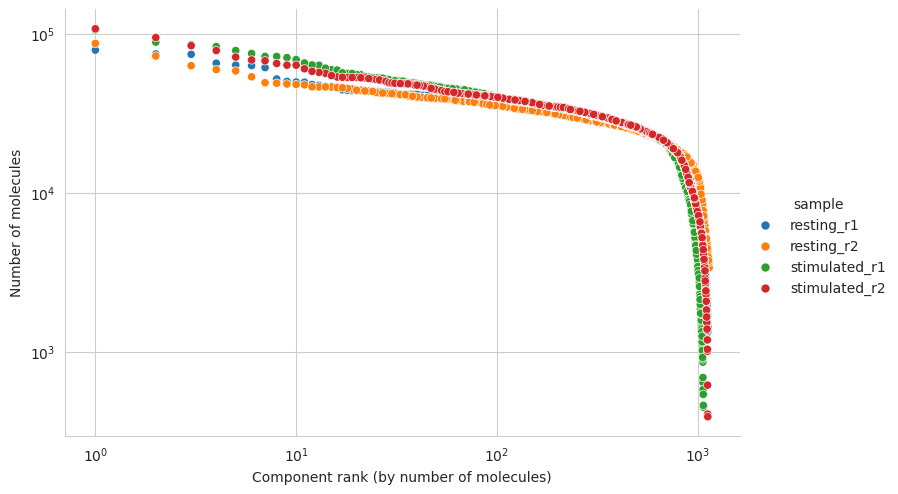

In [59]:
molecule_rank_df = adata.obs[["sample", "molecules"]].copy()
molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
    ascending=False, method="first"
)
fig, ax = molecule_rank_plot(molecule_rank_df, group_by="sample")

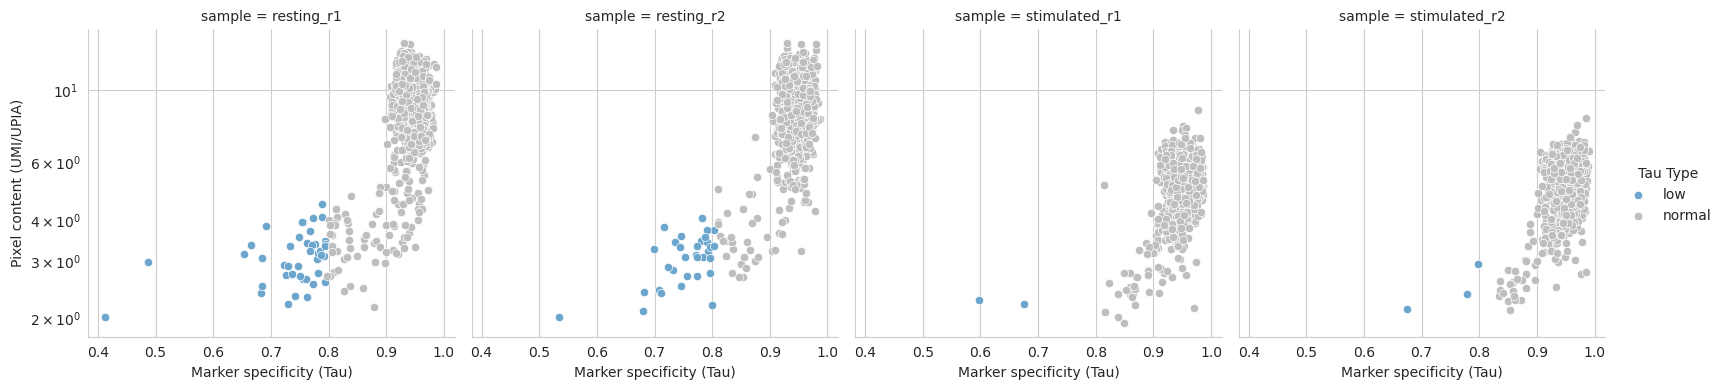

In [60]:
tau_metrics_df = adata.obs[["sample", "tau", "mean_molecules_per_a_pixel", "tau_type"]]
tau_metrics_df = tau_metrics_df.rename(columns={"mean_molecules_per_a_pixel": "umi_per_upia"})


fig, ax = scatter_umi_per_upia_vs_tau(tau_metrics_df, group_by="sample")

## Antibody variance increases with mean, most antibodies are present in all cells

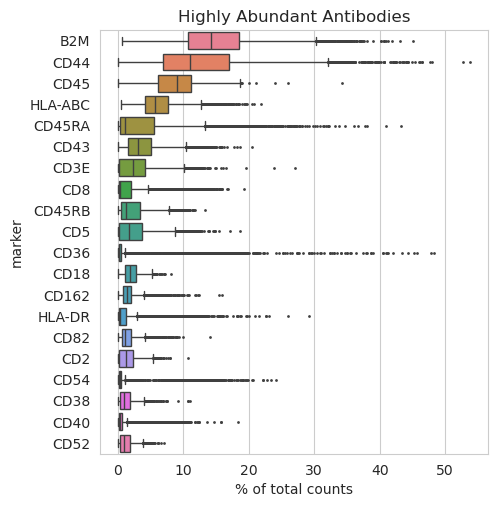

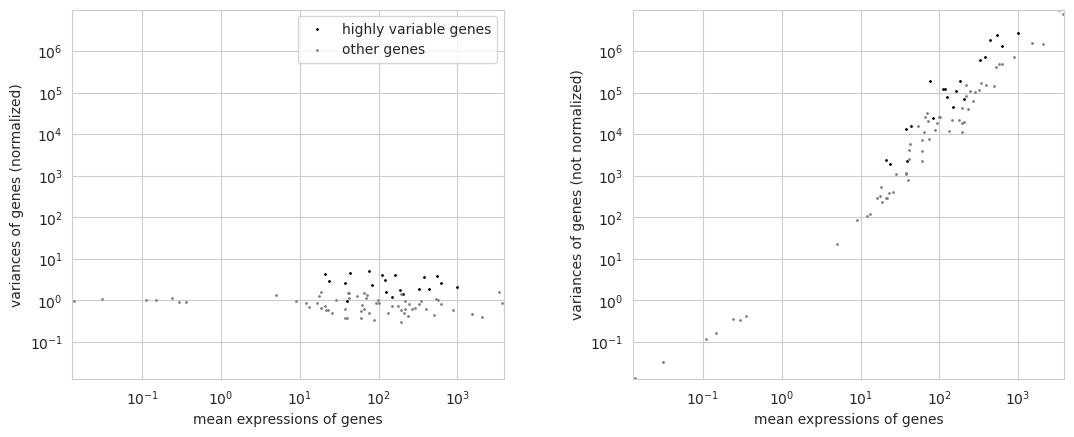

In [61]:
# assert adata.X[0,0] == adata.layers['counts'][0,0]
ax = sc.pl.highest_expr_genes(adata, n_top=20, show=False)
ax.set_title('Highly Abundant Antibodies')
var_genes = sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=20, batch_key='sample', layer='counts', inplace=False)
sc.pl.highly_variable_genes(var_genes, show=True, log=True)

In [62]:
import itertools

counts_df = adata.to_df()
n_total_cells = counts_df.shape[0]
n_antibodies = counts_df.shape[1]

stacked_df_w_sample = counts_df.transpose().stack().reset_index().rename(columns={0:'count'}).join(adata.obs['sample'], on='component', validate='m:1')
sample_size_df = pd.DataFrame({'sample': SAMPLE_NAMES, 'unfiltered_sample_size':[len(adata.obs[adata.obs['sample'] == name]) for name in SAMPLE_NAMES]}).set_index('sample')
counts_df = adata.to_df()
stacked_df_w_sample = counts_df.transpose().stack().reset_index().rename(columns={0:'count'}).join(adata.obs['sample'], on='component', validate='m:1')

adata.uns['counts_per_sample'] = {}
for sample in SAMPLE_NAMES:
    sample_stacked = stacked_df_w_sample[stacked_df_w_sample['sample'] == sample]
    sample_pivoted = pd.pivot_table(sample_stacked, index='component', columns='marker', values='count')
    adata.uns['counts_per_sample'][sample] = sample_pivoted

abundance_thresh = 10


threshed_stacked_df_w_sample = stacked_df_w_sample[stacked_df_w_sample['count'] > abundance_thresh]
n_components_df_w_sample = threshed_stacked_df_w_sample.groupby(['marker', 'sample'])['component'].count().reset_index()
n_components_df_w_sample = n_components_df_w_sample.join(sample_size_df, on='sample')

n_components_df_w_sample['Percent of Sample'] = n_components_df_w_sample['component']*100 / n_components_df_w_sample['unfiltered_sample_size']


antibody_pairs_names = list(itertools.combinations(adata.var_names, 2))
antibody_pairs_prod_samples = [(markers[0], markers[1], sample_name) for markers, sample_name in itertools.product(antibody_pairs_names, SAMPLE_NAMES)]
antibody_count_per_pair_per_sample = pd.DataFrame(index=pd.MultiIndex.from_tuples(antibody_pairs_prod_samples, names=['marker_1', 'marker_2', 'sample']), columns={'Cell Count': pd.Series(dtype=int), 'Percent of Sample': pd.Series(dtype=float)})
for sample in SAMPLE_NAMES:
    sample_count = adata.uns['counts_per_sample'][sample]
    for i, (ab_1, ab_2) in enumerate(antibody_pairs_names):
        index = (ab_1, ab_2, sample)
        antibody_count_per_pair_per_sample.at[index, 'Cell Count'] = cell_count = len(sample_count[(sample_count[ab_1] > abundance_thresh) & (sample_count[ab_2] > abundance_thresh)])
        antibody_count_per_pair_per_sample.at[index, 'Percent of Sample'] = 100*cell_count / sample_size_df.loc[sample, 'unfiltered_sample_size']


antibody_count_per_pair_per_sample = antibody_count_per_pair_per_sample.reset_index()


antibody_variation_df = adata.to_df().aggregate(['mean', 'std']).transpose()
antibody_variation_df['std/mean'] = antibody_variation_df['std'] / antibody_variation_df['mean']


/tmp/ipykernel_3576586/3141128191.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n_components_df_w_sample = threshed_stacked_df_w_sample.groupby(['marker', 'sample'])['component'].count().reset_index()


Text(0.5, 1.0, '% of Cells Per Antibody Pairs (Abundance > 10)')

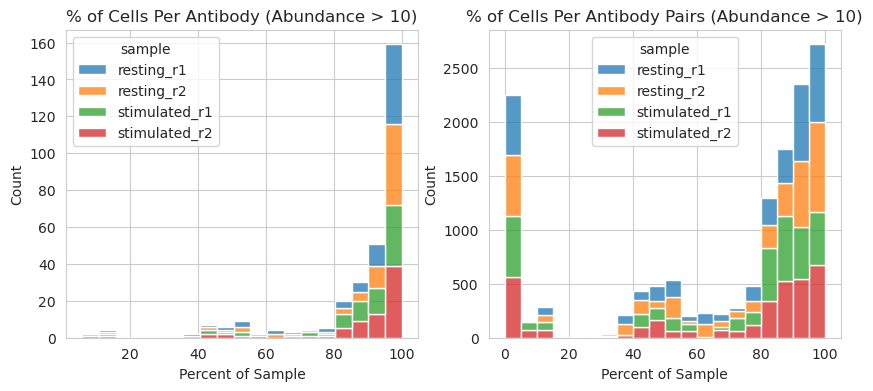

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(n_components_df_w_sample, x='Percent of Sample', ax=ax[0], binwidth=5, hue='sample', multiple='stack',)
ax[0].set_title(f'% of Cells Per Antibody (Abundance > {abundance_thresh})')

sns.histplot(antibody_count_per_pair_per_sample, x='Percent of Sample', ax=ax[1], binwidth=5, hue='sample', multiple='stack')
ax[1].set_title(f'% of Cells Per Antibody Pairs (Abundance > {abundance_thresh})')


In [64]:
# antibody_variation_df.sort_values(by='mean', axis=0, ascending=False, inplace=True)
antibody_variation_df[antibody_variation_df['mean'] < 10].index

Index(['CD123', 'CD180', 'CD191', 'CD192', 'CD24', 'CD335', 'CD39', 'CD58',
       'CD94'],
      dtype='object', name='marker')

In [66]:
components_to_keep = adata.obs[
    (adata.obs["molecules"] >= 10000)
    & (adata.obs["tau_type"] == "normal")
    & (adata.obs["tau"] > 0.9)
    & (adata.obs['a_pixels'] <= 10000)  # Removing outlier with 20K A pixels
].index

markers_to_keep = adata.var[
    adata.var['mean_counts'] >= 10
].index


orig_pg_data = pg_data
pg_data = orig_pg_data.filter(components=components_to_keep, markers=markers_to_keep)
adata = pg_data.adata
adata.layers['raw_filtered_counts'] = adata.X.copy()
adata.layers['counts'] = adata.X.copy()
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True, var_type='antibodies')
# os.remove(DATA_DIR/ "Sample06_V2_PBMC_r2.layout.dataset_FILTERED.pxl")
# pg_data.save(DATA_DIR/ "Sample06_V2_PBMC_r2.layout.dataset_FILTERED.pxl", force_overwrite=True)

## DSB and CLR Normalization
DSB normalization should be taking care of "background noise" adding to the marker counts, due to non-specific binding.
However it does not work in all cases, it relies on having positive (=the marker should exist) and negative (=the marker should not exist) cell populations for each (?) marker.  
Q: Should we be normalizing for each sample separately, or together (currently together)?

In [67]:
from pixelator.analysis.normalization import dsb_normalize
from pixelator.statistics import clr_transformation

adata.layers['dsb'] = dsb_normalize(adata.to_df(), isotype_controls=["mIgG1", "mIgG2a", "mIgG2b"])
adata.layers['log1p'] = np.log1p(adata.to_df())
adata.layers['clr'] = clr_transformation(adata.to_df(), axis=1)


Text(0.5, 1.0, 'CLR')

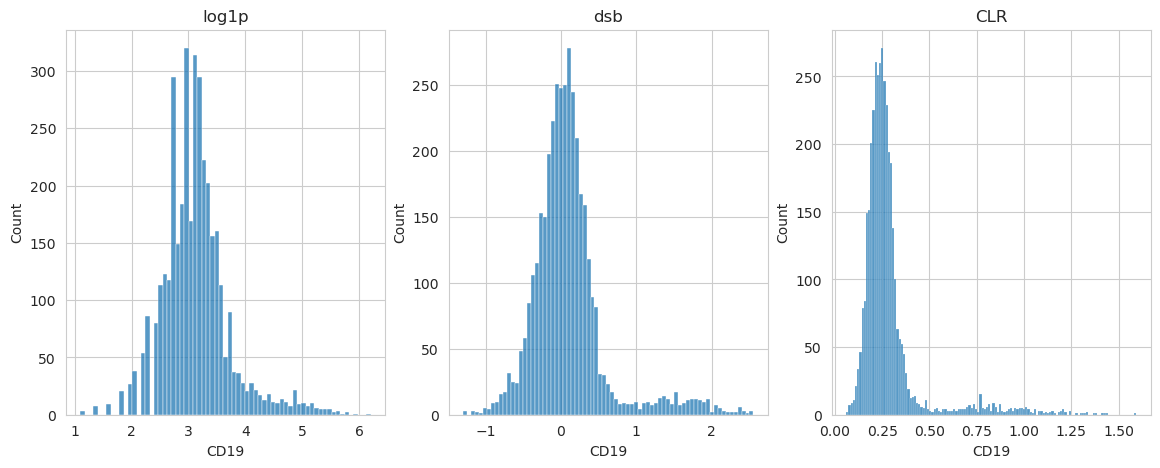

In [68]:
# CD19 marker
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
sns.histplot(data=adata.to_df('log1p'), x='CD19', ax=axes[0])
axes[0].set_title('log1p')
sns.histplot(data=adata.to_df('dsb'), x='CD19', ax=axes[1])
axes[1].set_title('dsb')
sns.histplot(data=adata.to_df('clr'), x='CD19', ax=axes[2])
axes[2].set_title('CLR')

In [69]:
adata.X = adata.layers['clr'].copy()

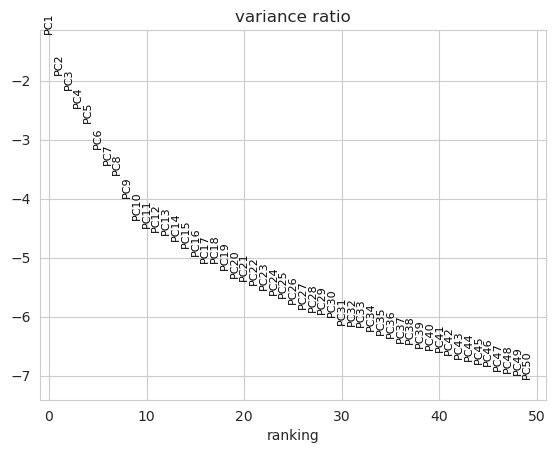

Text(0.5, 1.0, 'CD4 (T Helper)')

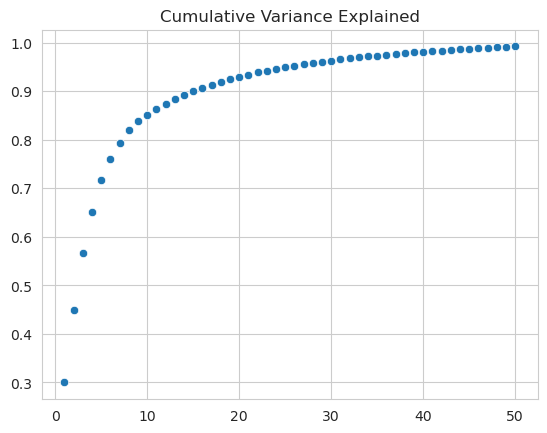

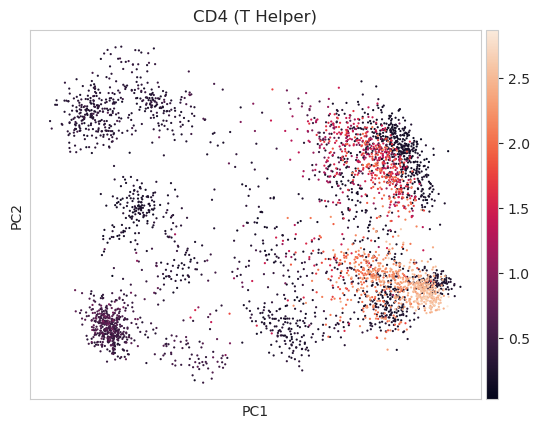

In [70]:
n_pcs = 50
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=n_pcs, log=True)

fig, ax = plt.subplots(1)
var_ratio_accum = np.cumsum(adata.uns['pca']['variance_ratio'])
sns.scatterplot(x=list(range(1, n_pcs + 1)), y=var_ratio_accum, markers=[f'$PC{i}$' for i in range(1, n_pcs + 1)])
ax.set_title('Cumulative Variance Explained')
ax = sc.pl.pca(
    adata,
    color=["CD4",],
    dimensions=[(0, 1)],
    size=10,
    show=False
)
ax.set_title('CD4 (T Helper)')


## No significant batch effect, but stimulated vs non-stimulated are nicely separated

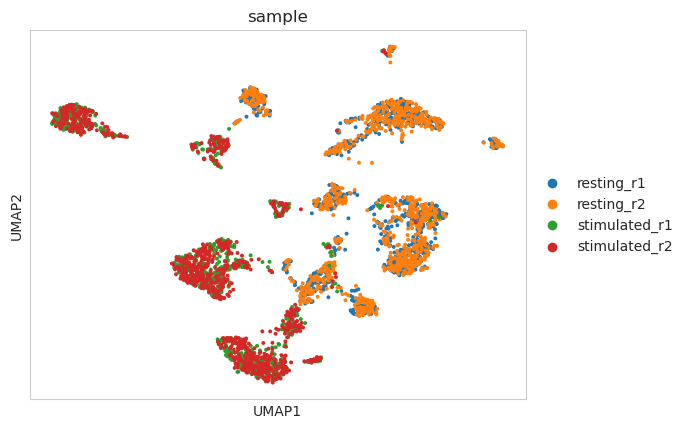

In [71]:
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)
sc.pl.umap(adata, color='sample')

## Normalized count data nicely separates cell types

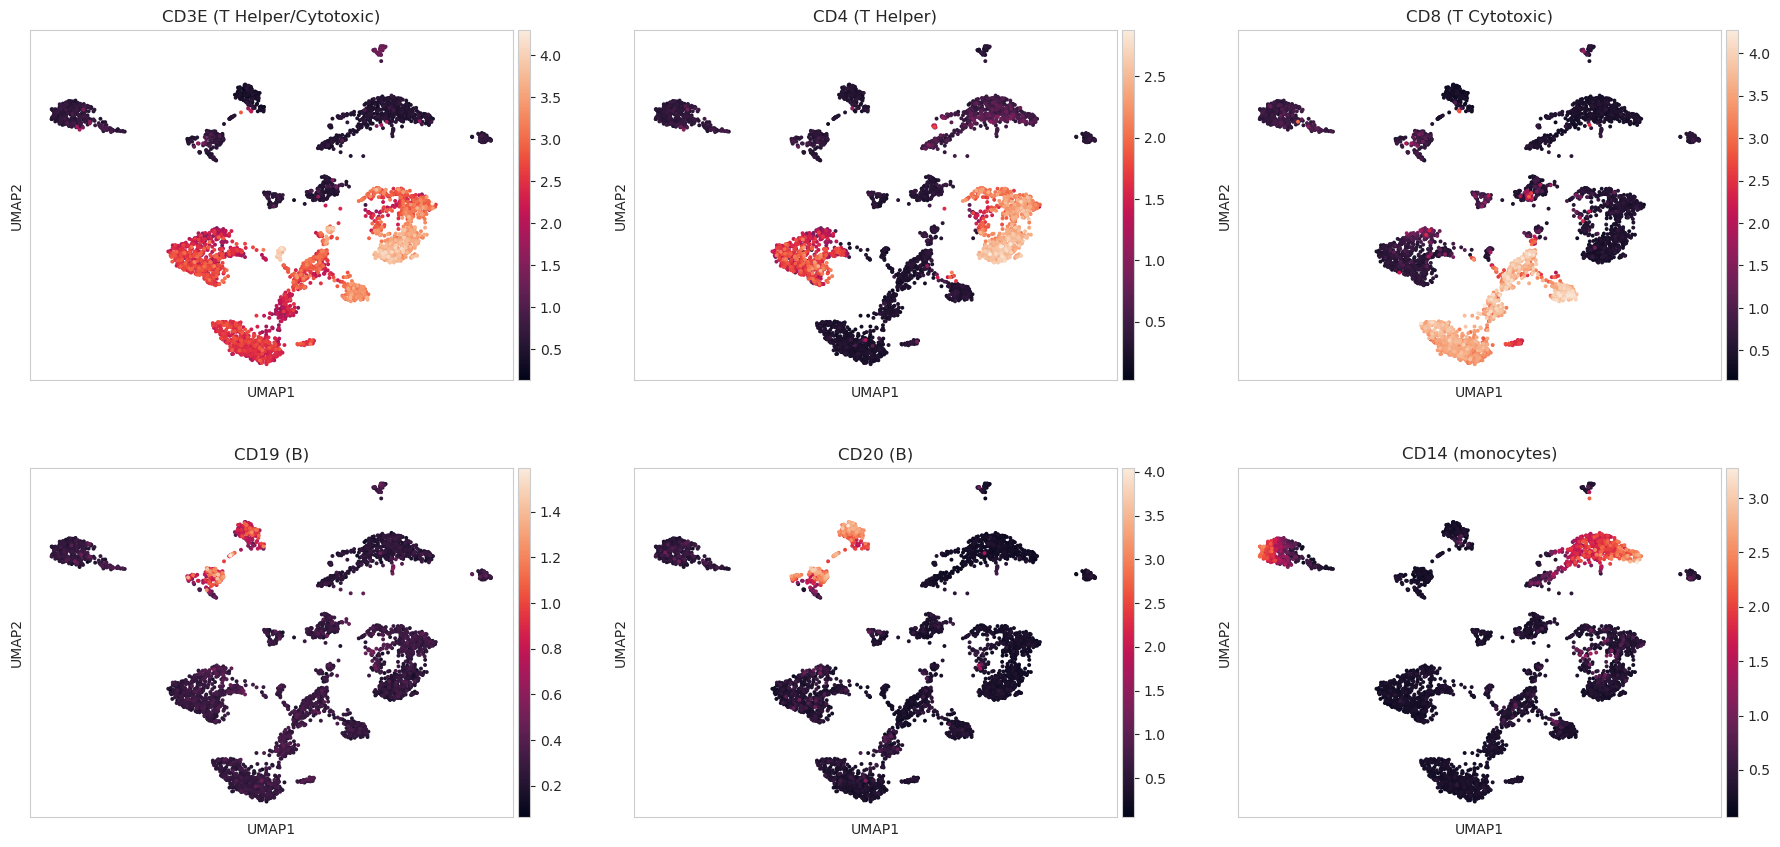

In [72]:
markers_of_interest = ["CD3E", "CD4", "CD8", "CD19", "CD20", "CD14"]
titles = ["CD3E (T Helper/Cytotoxic)", "CD4 (T Helper)", "CD8 (T Cytotoxic)", "CD19 (B)", "CD20 (B)", "CD14 (monocytes)"]
sc.pl.umap(adata, color=markers_of_interest, ncols=3, layer='clr', title=titles)

## No significant abundance imbalance across cell types

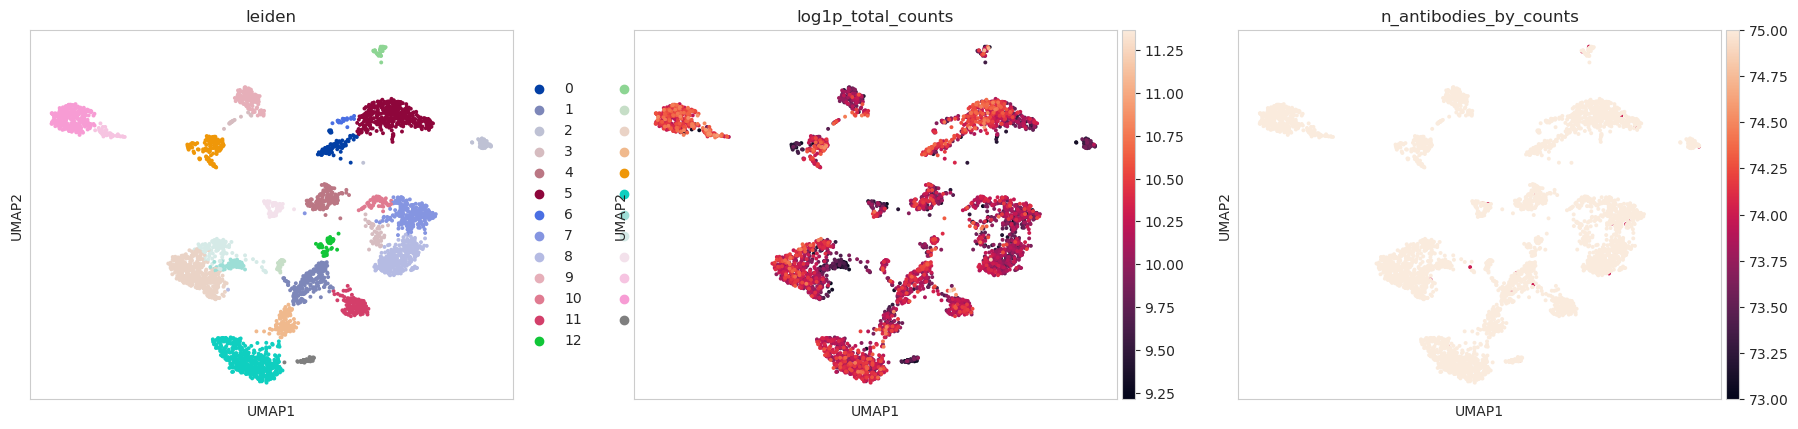

In [74]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
sc.pl.umap(adata, color=['leiden', 'log1p_total_counts', 'n_antibodies_by_counts'], ncols=3)

## Differential Abundance

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site

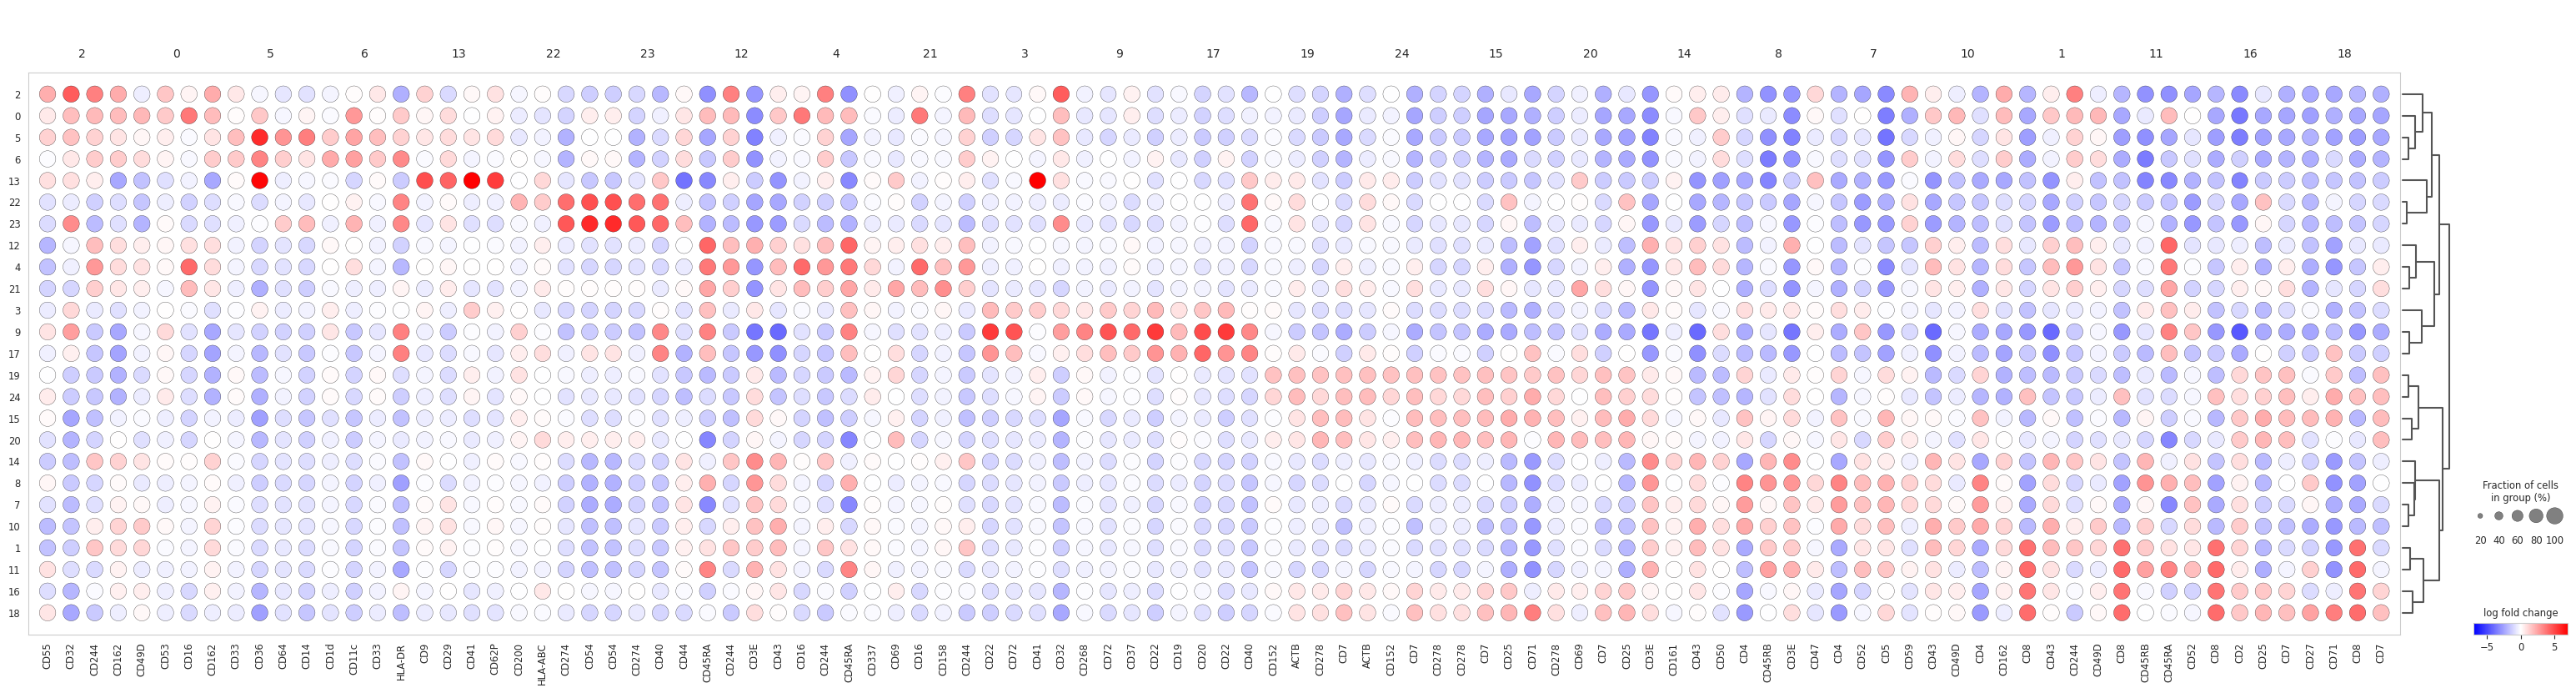

In [79]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, values_to_plot="logfoldchanges",
    min_logfoldchange=1,
    vmax=7,
    vmin=-7,
    cmap="bwr",
    groupby="leiden",
)


## Key takeaways
1. ~1000 cells per sample, most cells have 10K-40K antibodies sequenced
2. Most antibodies (out of 84) are present on all cells, with the most abundant accounting for a large chunk of the counts. Antibody pair distributions may be slightly more informative
3. There is no apparent batch effect and standard preprocessing allows to nicely view cell types.
4. 95% of variance is explained (PCA) with 20 PCs

In [81]:
# adata.write(filename=DATA_DIR / "Sample05_06_V2_PBMC_FILTERED_NORMALIZED.h5ad")
pg_data.save(DATA_DIR / COMBINED_PROCESSED_NAME, force_overwrite=True)

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing write_elem from `anndata.experimental` is deprecated. Import anndata.io.write_elem instead.
  warnings.warn(msg, FutureWarning)


## Graph Properties EDA

Reminder: each cell is a bipartite graph with left-side nodes being A pixels and right-side nodes being B pixels. Each edge between two pixels has a UMI that siginifies that that molecule was hybridized by both of those pixels, i.e. is in both of those small spatial areas.

Each cell has around 2000 A nodes and 1000 B nodes. Each A node has around 9 edges, to 3 distinct B nodes. Each B node is connected to around 6 distinct A nodes.

Each edge corresponds to a molecule, therefore # molecules = # edges which is centered around 20,000 as we saw in the Abundance EDA.

### Cells in different states have different properties
Namely, the stimulated cells have more pixels (local neighborhoods), less connectivity between pixels and less molecules per pixel

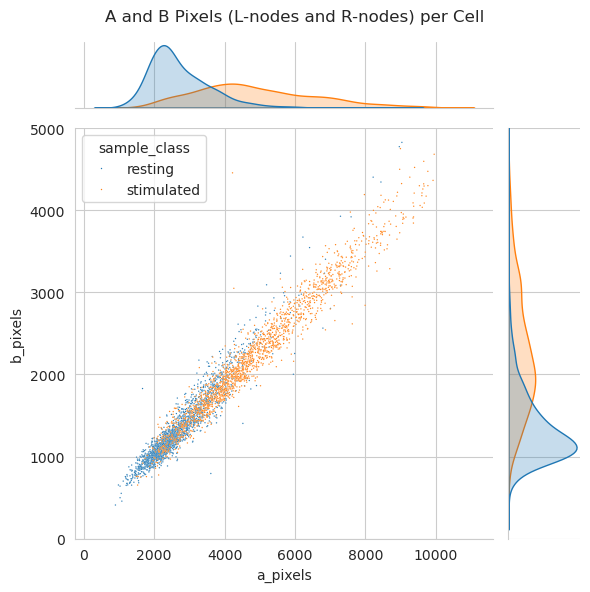

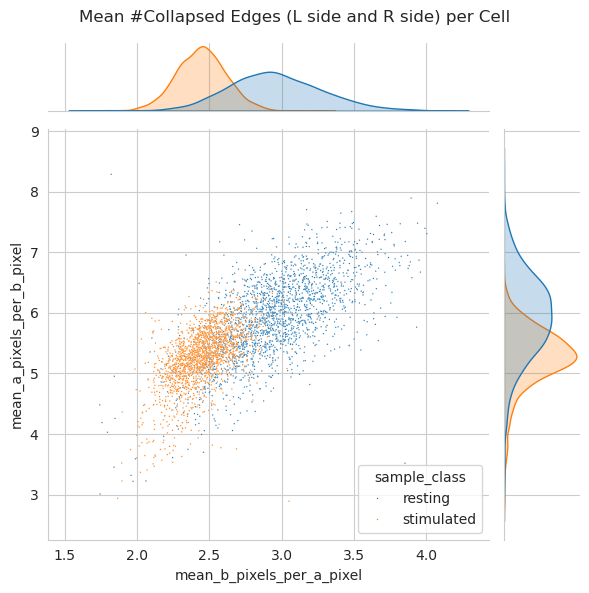

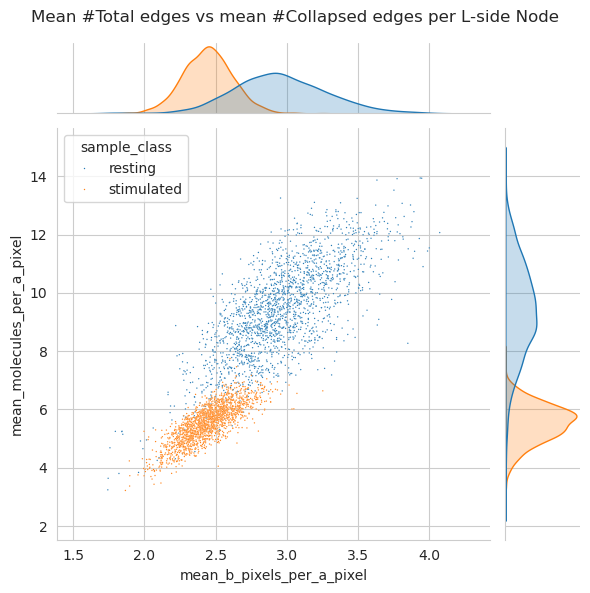

In [100]:
adata.obs['sample_class'] = 'stimulated'
adata.obs['sample_class'] = adata.obs['sample_class'].where((adata.obs['sample'] == 'stimulated_r1') | (adata.obs['sample'] == 'stimulated_r2'), 'resting')

jg  = sns.jointplot(adata.obs, x='a_pixels', y='b_pixels', kind='scatter', s=1, hue='sample_class', ylim=(0, 5000))
jg.figure.suptitle('A and B Pixels (L-nodes and R-nodes) per Cell')
jg.figure.tight_layout()

jg  = sns.jointplot(adata.obs, x='mean_b_pixels_per_a_pixel', y='mean_a_pixels_per_b_pixel', kind='scatter', s=1, hue='sample_class', color=sns.color_palette()[1])
jg.figure.suptitle('Mean #Collapsed Edges (L side and R side) per Cell')
jg.figure.tight_layout()

jg  = sns.jointplot(adata.obs, x='mean_b_pixels_per_a_pixel', y='mean_molecules_per_a_pixel', kind='scatter', s=1, hue='sample_class', color=sns.color_palette()[2])
jg.figure.suptitle('Mean #Total edges vs mean #Collapsed edges per L-side Node')
jg.figure.tight_layout()


## Colocalization
The data comes with colocalization scores per pairs of markers per cell, calculated in two ways:
1. A Pearson's correlation between counts of the two markers in small areas, and a Z score calculated based on the r value
2. Jaccard index, which measures similarity between all neighborhoods containing each marker (And a Z score for Jaccard as well).

In [118]:
pd.pivot_table(all_samples_filtered_coloc, index='marker_1', columns='marker_2', values='pearson_z')

marker_2,CD158,CD16,CD1d,CD20,CD22,CD25,CD27,CD274,CD279,CD29,...,CD62P,CD69,CD7,CD71,CD72,CD8,CD86,CD9,HLA-DR,TCRVB5
marker_1,,,,,,,,,,,,,,,,,,,,,
CD158,1.000000,0.457924,0.657708,0.755245,0.750314,0.781643,0.469412,0.458661,0.583240,0.224252,...,0.529429,0.669030,0.568929,0.507414,0.602873,0.474196,0.327476,0.537804,0.392850,0.601641
CD16,0.457924,1.000000,0.244063,0.190187,0.374815,0.329712,0.193576,0.252682,0.187886,0.160232,...,0.053820,0.228027,0.158987,0.250930,0.158626,0.063978,0.162613,0.272527,0.000109,0.432195
CD1d,0.657708,0.244063,1.000000,0.461377,0.567724,0.338675,0.328118,0.522838,0.395473,0.119233,...,0.500077,0.386331,0.436402,0.405543,0.354063,0.065685,0.499565,0.560301,0.503929,0.481221
CD20,0.755245,0.190187,0.461377,1.000000,2.186570,0.680786,-0.454566,0.523987,0.377154,0.222987,...,0.318331,0.743788,-0.120086,0.120495,1.085194,0.294348,1.209586,0.465710,4.506994,0.560986
CD22,0.750314,0.374815,0.567724,2.186570,1.000000,0.694280,0.097322,0.564813,0.538150,0.054713,...,0.404330,0.579996,0.337533,0.366463,0.988951,0.130312,0.750957,0.560119,1.461531,0.602920
CD25,0.781643,0.329712,0.338675,0.680786,0.694280,1.000000,0.154344,0.252859,0.377513,0.597833,...,0.498199,0.735480,1.042779,0.794948,0.437201,0.846409,0.315641,0.564523,0.421813,0.383876
CD27,0.469412,0.193576,0.328118,-0.454566,0.097322,0.154344,1.000000,0.191939,0.512376,-0.454001,...,0.228278,0.142471,1.234181,1.311029,0.072046,0.460284,-0.171688,0.279017,-0.854285,0.392603
CD274,0.458661,0.252682,0.522838,0.523987,0.564813,0.252859,0.191939,1.000000,0.373321,0.283093,...,0.401441,0.287232,0.198359,0.324150,0.430980,-0.005279,0.856651,0.283775,0.872145,0.421674
CD279,0.583240,0.187886,0.395473,0.377154,0.538150,0.377513,0.512376,0.373321,1.000000,0.067067,...,0.558208,0.467992,0.495442,0.448139,0.379585,0.261773,0.377386,0.404743,0.155640,0.436764


TypeError: seaborn.matrix.heatmap() got multiple values for keyword argument 'ax'

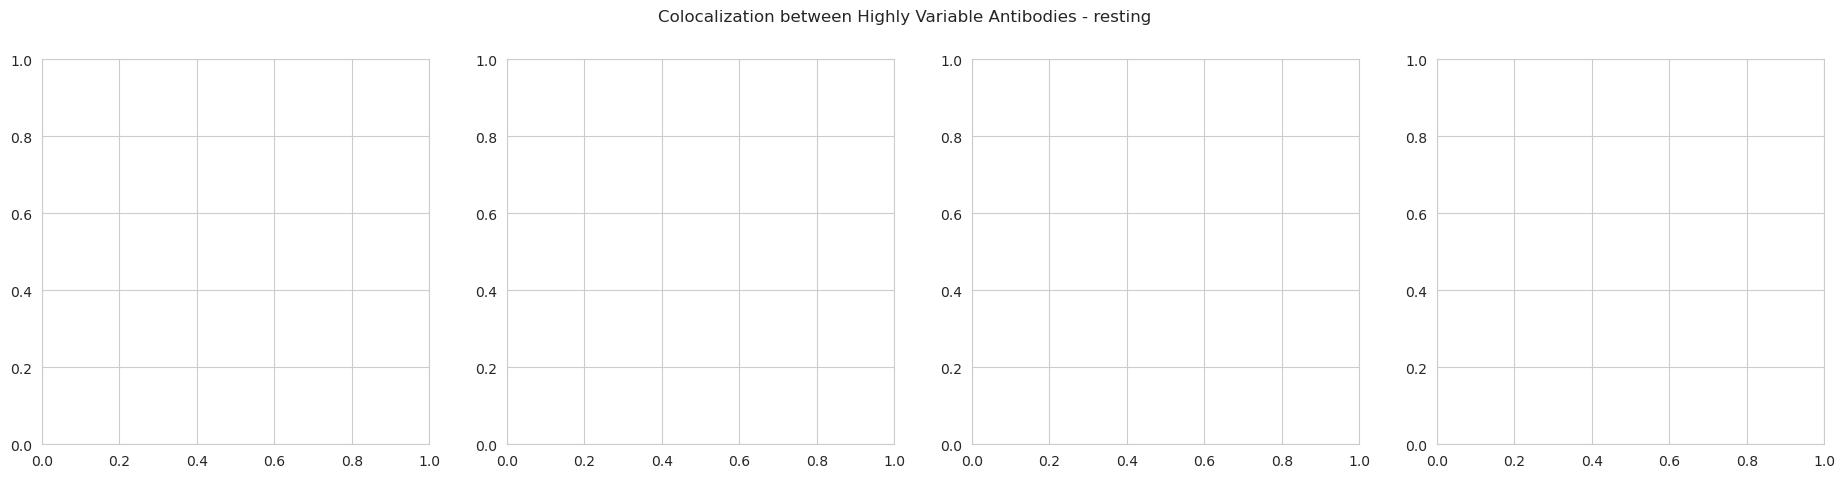

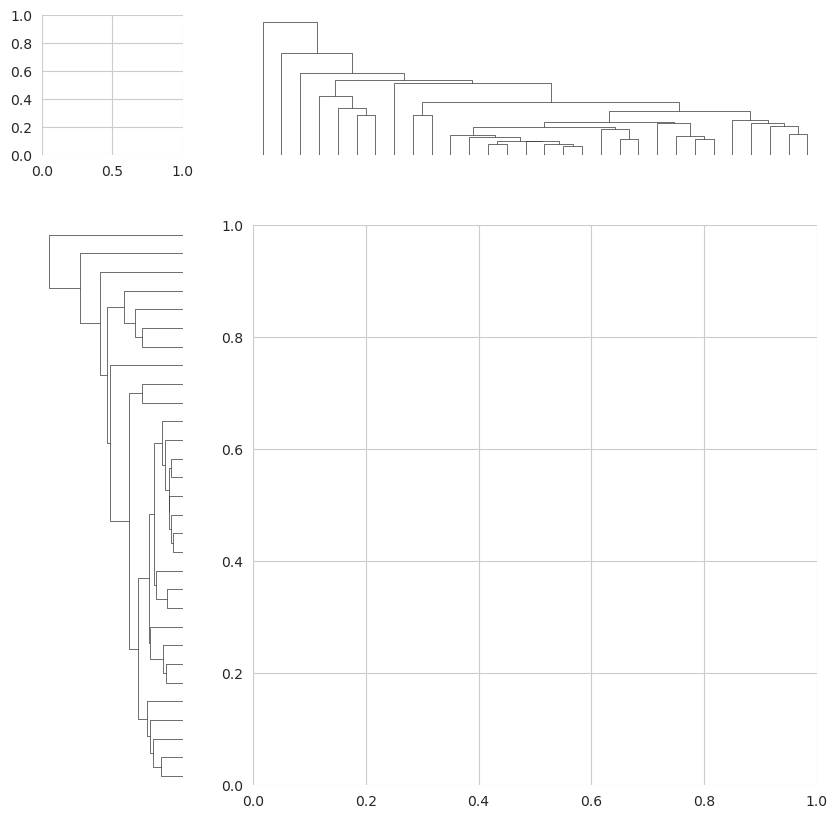

In [119]:
# Rank markers by variability
variable_markers = sc.pp.highly_variable_genes(adata, layer='counts', n_top_genes=30, flavor='seurat_v3', inplace=False)
highly_variable_marker_names = variable_markers[variable_markers['highly_variable']].index
# variable_markers.sort_values(by='highly_variable_rank', ascending=True, inplace=True)
# print(variable_markers.reset_index().head(5))
# top_markers = variable_markers.index[:15]
# # print(top_markers)
coloc = pg_data.colocalization.copy()

# Make symmetric
coloc = pd.concat(
    [coloc,
     coloc.copy().rename(columns={'marker_1': 'marker_2', 'marker_2': 'marker_1'})],
     axis=0,
)

fake_auto_correlation = pd.DataFrame([
    {'marker_1': marker, 'marker_2': marker, 'pearson_z': 1, 'jaccard_z': 1, 'sample': sample} for marker in highly_variable_marker_names for sample in SAMPLE_NAMES
])

coloc = pd.concat(
    [coloc, fake_auto_correlation],
    axis=0
)

coloc = coloc.join(variable_markers['highly_variable'], on='marker_1', validate='many_to_one')
coloc.rename(columns={'highly_variable': 'marker_1_highly_variable'}, inplace=True)
coloc = coloc.join(variable_markers['highly_variable'], on='marker_2', validate='many_to_one')
coloc.rename(columns={'highly_variable': 'marker_2_highly_variable'}, inplace=True)
coloc['highly_variable_pair'] = coloc['marker_1_highly_variable'] & coloc['marker_2_highly_variable']

all_samples_filtered_coloc = coloc[coloc['highly_variable_pair']]
sample_classes = {'resting': ['resting_r1', 'resting_r2'], 'stimulated': ['stimulated_r1', 'stimulated_r2']}

for sample_class, sample_names in sample_classes.items():
    filtered_coloc = all_samples_filtered_coloc[all_samples_filtered_coloc['sample'].isin(sample_names)]

    fig, ax = plt.subplots(1, 4, figsize=(23, 5))
    fig.suptitle(f'Colocalization between Highly Variable Antibodies - {sample_class}')
    
    pivoted_coloc = pd.pivot_table(filtered_coloc, values='pearson_z', index='marker_1', columns='marker_2', aggfunc='mean')
    # sns.heatmap(pivoted_coloc, center=0, cmap=sns.color_palette("vlag", as_cmap=True), xticklabels=True, yticklabels=True, ax=ax[0])
    sns.clustermap(pivoted_coloc, center=0, cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[0])
    ax[0].set_title("Pearson's r z score, mean across cells")
    pivoted_coloc = pd.pivot_table(filtered_coloc, values='jaccard_z', index='marker_1', columns='marker_2', aggfunc='mean')
    sns.heatmap(pivoted_coloc, center=0, cmap=sns.color_palette("vlag", as_cmap=True), xticklabels=True, yticklabels=True, ax=ax[1])
    ax[1].set_title("Jaccard z score, mean across cells")

    ax[0].grid(False)
    ax[1].grid(False)
    # pg_data_1.colocalization.groupby(['marker_1', 'marker_2']).aggregate('')

    scores_corr = filtered_coloc.groupby(['marker_1', 'marker_2'])[['pearson_z', 'jaccard_z']].corr().iloc[0::2,-1].reset_index().drop(columns=['level_2']).rename(columns={'jaccard_z': 'Pearson-Jaccard Correlation'})
    pivoted_corr = pd.pivot_table(scores_corr, values='Pearson-Jaccard Correlation', index='marker_1', columns='marker_2')
    sns.heatmap(pivoted_corr, xticklabels=True, yticklabels=True, ax=ax[2], cmap=sns.light_palette("seagreen", as_cmap=True))
    ax[2].grid(False)
    ax[2].set_title('Pearson-Jaccard Correlation Across Cells')

    pivoted_coloc = pd.pivot_table(filtered_coloc, values='component', index='marker_1', columns='marker_2', aggfunc='count')
    sns.heatmap(pivoted_coloc, cmap=sns.light_palette("orange", as_cmap=True), xticklabels=True, yticklabels=True, ax=ax[3])
    ax[3].grid(False)
    ax[3].set_title("Cell Count Per Pair")


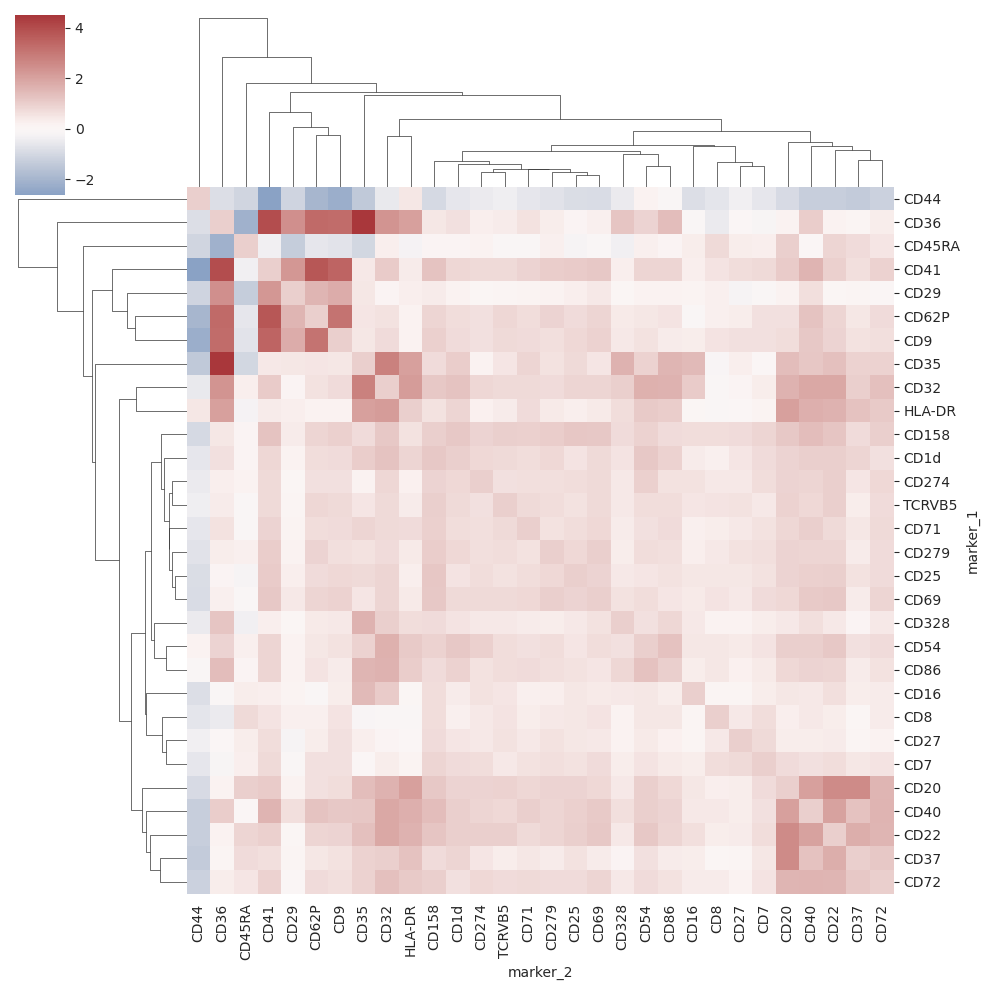

In [121]:
sns.clustermap(pivoted_coloc, center=0, cmap=sns.color_palette("vlag", as_cmap=True))

## Example of Low Correlation Pair

(-50.0, 50.0)

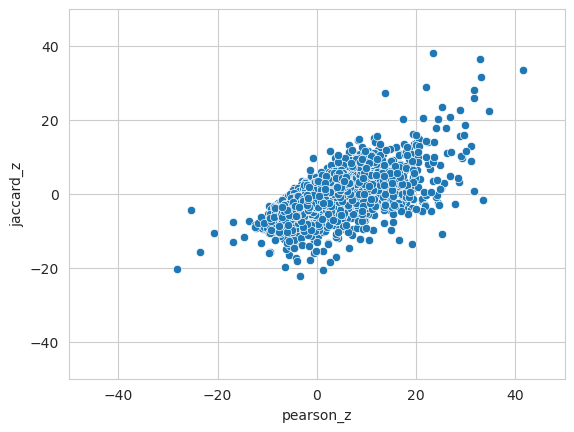

In [84]:
# sns.scatterplot(filtered_coloc[(filtered_coloc['marker_1'] == 'CD192')&(filtered_coloc['marker_2']=='CD44')], x='pearson_z', y='jaccard_z')
ax = sns.scatterplot(filtered_coloc[(filtered_coloc['marker_1'] == 'CD36')&(filtered_coloc['marker_2']=='CD62P')], x='pearson_z', y='jaccard_z',)
ax.set_xlim((-50, 50))
ax.set_ylim((-50, 50))